# Google's Inceptionv3 CNN

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [ ]:
# check if gpu present
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Datasets, transforms and visualisations

In [ ]:
# earlier had used ToTensor() of "transform" to convert PIL image to tensor directly
# This time using few more functions of "transform"

transform_train = transforms.Compose([
      transforms.RandomResizedCrop(224),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
      transforms.RandomResizedCrop(224),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

Downloading and applying the transform object pipelined above

In [ ]:
trainset = torchvision.datasets.CIFAR10(root = './data', train = True,
                                        download = True, 
                                        transform = transform_train) # applying transform in this last line

testset = torchvision.datasets.CIFAR10(root = './data', train = False,
                                        download = True, 
                                        transform = transform_test)
                                        

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
num_classes = 10

10 classes in CIFAR10

In [ ]:
batch_size = 4

visualise 4 at a time

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
# want shuffled instances of 4 images

In [ ]:
dataiter = iter(trainloader)
images , labels = dataiter.next() # gives next batch

print(images.shape)

print(images[1].shape)
print(labels[1].item()) # class

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
1


Note 32 x 32 of CIFAR has been converted to 224 x 224

In [ ]:
# to display image
# only change: unnormalize => multiplication by 0.5 (std. dev) and adding by 0.5 (mean)
# to unnormalize, convert image to numpy
# if don't normalize, too dark, since normalizing had reduced all the color intensity etc
def imshow(img, title):
  npimg = img.numpy()
  plt.figure(figsize = (batch_size, 1))
  plt.axis("off")
  plt.imshow(np.transpose(npimg, (1,2,0))) # i.e. putting the 3 channels at end
  plt.title(title)
  plt.show()


In [ ]:
# Show the entire batch together
def show_batch_images(dataloader):
  images, labels = next(iter(dataloader))
  img = torchvision.utils.make_grid(images)
  imshow(img, title = [str(x.item()) for x in labels])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


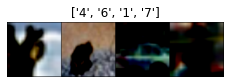

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


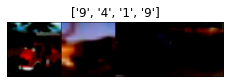

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


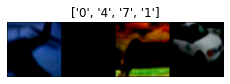

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


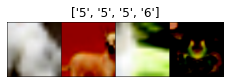

In [ ]:
for i in range(4):
  show_batch_images(trainloader)

# Helper Functions

In [ ]:
def evaluation(dataloader, model):
  total, correct = 0, 0
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, pred = torch.max(outputs.data, 1) # index at which max value
    total += labels.size(0)
    correct += (pred == labels).sum().item()
  return 100 * correct / total

In [ ]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle = False)

# Inception Model

Torchvision

Repeating modules with Parallel paths and dangling (auxillary outputs - useful during training)

In [ ]:
inception = torchvision.models.inception_v3(pretrained = True)

In [ ]:
print(inception)

InceptionA, Inception B, C, D, E (a class of those paralled layers) like BuildingBlock in ResNet

NOte very very large network  
InceptionAux to make sure gradients flow through

Finally is fc (fully connected neural layer)

In [ ]:
for param in inception.parameters():
  param.requires_grad = False

Change # of classes in "auxillary" and "final" outputs

First, auxillary

In [ ]:
aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

In [ ]:
for param in inception.parameters():
  if(param.requires_grad):
    print(param.shape)

Now output

In [ ]:
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, num_classes)

In [ ]:
for param in inception.parameters():
  if(param.requires_grad):
    print(param.shape)

Shows that now both auxillary and final output are changed (# classes)

Also, for inception input size is 299 x 299, so resize/transform

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root = './data', train = True,
                                        download = True, 
                                        transform = transform_train) # applying transform in this last line

testset = torchvision.datasets.CIFAR10(root = './data', train = False,
                                        download = True, 
                                        transform = transform_test)
                                        

### Training Inception

In [ ]:
inception = inception.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(), lr = 0.01) # stochastic

Slight change in evaluation: See in the code of inception, during forward pass, it returns both final and auxillary output, so you have to take the aux outputs too. (though you won't use them)

In [ ]:
def evaluation_inception(dataloader, model):
  total, correct = 0, 0
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs, aux_outputs = model(inputs)
    _, pred = torch.max(outputs.data, 1) # index at which max value
    total += labels.size(0)
    correct += (pred == labels).sum().item()
  return 100 * correct / total

Changes in learning loop commented

In [ ]:
loss_epoch_arr = []
max_epochs = 4

n_iters = np.ceil(50000/batch_size)

min_loss = 1000

for epoch in range(max_epochs):

  for i, data in enumerate(trainloader, 0):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()

    # one more output
    outputs, aux_outputs = inception(inputs)
    # sum up losses and then propagate (new feature in deep NNs)
    # main weightage given to main loss (weightage = 1), and smaller weightage to previous ones (0.3)
    loss = loss_fn(outputs, labels) + 0.3*loss_fn(aux_outptus, labels)

    loss.backward() 
    opt.step() 

    if loss.item() < min_loss: 
      min_loss = loss.item() 
      best_model = copy.deepcopy(inception.state_dict())
      print("Min loss %0.2f" % min_loss)

    if i%100 == 0:
      print("Iteration: %d/%d, Loss: %0.2f" % (i, n_iters, loss.item()))

    del inputs, labels, outputs
    torch.cuda.empty_cache()


  loss_epoch_arr.append(loss.item())

  # change evaluation metric
  print("Epoch: %d/%d, Test acc = %0.2f, Train acc = 0.2f" %(
      epoch, max_epochs,
      evaluation_inception(testloader, inception), evaluation_inception(trainloader, inception)))
  
  plt.plot(loss_epoch_arr)
  plt.show()

In [ ]:
inception.load_state_dict(best_model)
print(evaluation(trainloader, resnet), evaluation(testloader, resnet))